In [1]:
#Дописать рукками:
# 6) Модель GradientBoosting - прописать чтоб финальный прогноз строился только на оптимального кол-во деревьев

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
pd.set_option('display.max_columns', None)

# Класс модели Gradient Boosting (на решающих деревьях)

In [3]:
# Определение класса градиентного бустинга
class GradientBoosting():
    
    def __init__(self, eta=0.5, n_estimators=10, min_data_in_leaf=5, max_depth=10, random_state=42, model_type='regression', coefs=[], n_batches=1, split_points=-1):
        coefs = coefs if len(coefs) > 0 else np.linspace(1, 0.5, n_estimators+1)
        
        self.X_train = []                        # обучающие данные
        self.y_train = []                        # обучающие классы
        self.n_estimators = n_estimators         # кол-во решающих деревьев
        self.min_data_in_leaf = min_data_in_leaf # минимальное кол-во данных в терминаьном листе
        self.max_depth = max_depth               # максимальная глубина дерева
        self.eta = eta                           # learning rate
        self.coefs = coefs                       # коэфициенты при алгоритмах/деревья
        self.random_state = random_state         # random_state
        self.model_type = model_type               # тип предсказания 'Classificator', 'Regressor'
        self.forest = []                         # список корней решающих деревьев (по сути решающих деревьев)
        self.train_err = []                      # список ошибок на каждом из этапов тренировки
        self.valid_err = []                      # список ошибок валидационного датасета на каждом из этапов тренировки
        self.n_batches = n_batches               # кол-во частей для разбивки датасета для стахастического градиентного бустинга
        self.split_points = split_points         # Кол-во точек разделения данных при построении ветвей (-1 - максимально возможное)
    
    
    # Класс узла дерева
    class Node:

        def __init__(self, index, t, left_branch, right_branch, depth=0):
            self.index = index               # индекс признака, по которому ведется сравнение с порогом в этом узле
            self.t = t                       # значение порога
            self.left_branch = left_branch   # поддерево, меньше порогового значения t (левая ветка)
            self.right_branch = right_branch # поддерево, больше порогового значения t (правая ветка)
            self.depth = depth               # глубина 
    
        # Функция предсказания для отдельного объекта
        def obj_predict(self, obj):
            if obj[self.index] <= self.t:
                return self.left_branch.obj_predict(obj)
            else:
                return self.right_branch.obj_predict(obj)
        
        def obj_predict_proba(self, obj):
            if obj[self.index] <= self.t:
                return self.left_branch.obj_predict_proba(obj)
            else:
                return self.right_branch.obj_predict_proba(obj)         
        
        # Функция формирования предсказания по выборке на одном дереве
        def predict(self, data):
            return np.array([self.obj_predict(obj) for obj in np.array(data)])
                
        def predict_proba(self, data):          
            return np.array([self.obj_predict_proba(obj) for obj in np.array(data)])
        
    
    # Класс терминального листа
    class Leaf:
        def __init__(self, data, labels, depth, model_type):
            self.data = data
            self.labels = labels
            self.depth = depth
            self.model_type = model_type # тип предсказания 'Classificator', 'Regressor'
            self.prediction = self.obj_predict()
        
        def obj_predict(self, obj=None):
            if self.model_type == 'classification':
                return max(set(self.labels), key=list(self.labels).count)
            if self.model_type == 'regression':
                return np.mean(self.labels)
            
            return np.zeros(len(self.labels))
        
        def obj_predict_proba(self, obj=None):
            if self.model_type == 'classification':
                return max(set(self.labels), key=list(self.labels).count) / self.labels.shape[0]
            if self.model_type == 'regression':
                return np.zeros(self.labels.shape[0])
        
    # Построение дерева с помощью рекурсивной функции
    def create_tree(self, data, labels, depth=0):

        # выбор индекса из случайной подвыборки длиной sqrt(n_features)
        if self.model_type == 'classification':
            index_qty = int(np.sqrt(data.shape[1]))
        if self.model_type == 'regression':
            index_qty = max( int(round(np.sqrt(data.shape[1]),0)) , int(data.shape[1] / 3))
        
        # Построение дерева на всех признаках (только для случая GB)
        index_qty = data.shape[1]-1
        
        index_list = np.random.choice(range(data.shape[1]), index_qty+1, replace=False)
        quality, t, index = self.best_split(data, labels, index_list)
        
        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        if quality == float('Inf') or depth == self.max_depth:
            return self.Leaf(data, labels, depth, self.model_type)

        data_left, data_right, labels_left, labels_right = self.split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        branch_left = self.create_tree(data_left, labels_left, depth + 1)
        branch_right = self.create_tree(data_right, labels_right, depth + 1)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        return self.Node(index, t, branch_left, branch_right, depth)
    
    
    # Разбиение датасета в узле
    def split(self, data, labels, index, t):
        left = (data[:, index] <= t)
        right = (data[:, index] > t)
        return data[left], data[right], labels[left], labels[right]    

    
    # Расчет качества разбиения (чем меньше значение функции, тем лучше)
    def split_criteria(self, left_labels, right_labels):
        mse_err = lambda y, y_pred : np.mean((y - y_pred) ** 2)
        gini = lambda y: (1 - sum((np.unique(y, return_counts=True)[1] / len(y))**2))
        
        p = len(left_labels) / (len(left_labels) + len(right_labels))
        
        if self.model_type == 'Regressor':
            # Сумма среднеквадратичных отклонений по левой и правой выборке
            return p * (np.std(left_labels) ** 2)  + (np.std(right_labels) ** 2) * (1-p)
        else:
            # Доля выборки, ушедшая в левое поддерево

            # Расчет криетрия jini
            return (p * gini(left_labels) + (1 - p) * gini(right_labels))
    
    # Нахождение наилучшего разбиения
    def best_split(self, data, labels, index_list):            
        
        # формулы расчета критериев качества разбиения
        gini = lambda labels: (1 - sum((np.unique(labels, return_counts=True)[1] / len(labels))**2))
        gini_criteria = lambda p, left_labels, right_labels: p * gini(left_labels) + (1 - p) * gini(right_labels)
        mse_criteria = lambda p, left_labels, right_labels: p * np.var(left_labels)  + np.var(right_labels) * (1-p)       
        
        best_quality, best_t, best_index = float('Inf'), None, None
        
        #Перебор вариантов разбиения данных для построения дерева 
        for index in index_list:
            # определение точек для проверки при разбиении данных на ветви
            if self.split_points == -1:
                split_points = np.unique(data[:,index])
            else:
                split_points = np.unique(np.quantile(data[:,index], np.linspace(0, 1, self.split_points+1)))
            
            for t in split_points:      
                left_data, right_data, left_labels, right_labels = self.split(data, labels, index, t)
                
                # рассматриваем только те разбиения, в которых в узлах остается не менее min_data_in_leaf объектов
                if len(left_data) >= self.min_data_in_leaf and len(right_data) >= self.min_data_in_leaf:
                    p = len(left_labels) / (len(left_labels) + len(right_labels))
                    # Расчет Критерия качества разбиения
                    if self.model_type == 'regression':
                        cur_quality = p * np.var(left_labels)  + np.var(right_labels) * (1-p)
                    if self.model_type == 'classification':
                        cur_quality = p * gini(left_labels) + (1 - p) * gini(right_labels)                
                    
                    #  Определяем разбиение с лучшим качеством                
                    if cur_quality <  best_quality:
                        best_quality, best_t, best_index = cur_quality, t, index

        return best_quality, best_t, best_index
    
    
    # Построение леса
    def fit(self, X_train, y_train, X_valid=[], y_valid=[]):
        self.forest = []
        X_train = X_train.values
        y_train = y_train.values
        self.X_train = X_train
        self.y_train = y_train
        
        N = X_train.shape[0]
        batch_size = N // self.n_batches
        
        mse_err = lambda y, y_pred : np.mean((y - y_pred) ** 2)
        
        # Определение метода расчета сдвига
        if self.model_type == 'regression':
            bias = lambda y, z: y - z
        if self.model_type == 'classification':
            bias = lambda y, z: -y / (1+np.exp(-y*z))
        
        np.random.seed(self.random_state)
        
        for i in range(self.n_estimators):
            if len(self.forest) == 0:
                # первый алгоритм просто обучаем на выборке и добавляем в список
                tree = self.create_tree(X_train, y_train)
                self.forest.append(tree)
                self.train_err.append(mse_err(y_train, self.predict(X_train)))
                self.valid_err.append(mse_err(y_valid, self.predict(X_valid)))
            else:
                # алгоритмы начиная со второго обучаются на сдвиг   
                for batch in range(self.n_batches):
                    
                    batch_index = range(batch_size * batch, batch_size * (batch + 1) if batch < (self.n_batches-1) else N) 
                    X_train_batch = X_train[batch_index]
                    y_train_batch = y_train[batch_index]
                    
                    tree = self.create_tree(X_train_batch, bias(y_train_batch, self.predict(X_train_batch)))   
            
                    self.forest.append(tree)
                    self.train_err.append(mse_err(y_train, self.predict(X_train)))
                    self.valid_err.append(mse_err(y_valid, self.predict(X_valid)))
                    
                    if len(self.forest) == self.n_estimators: break
            if len(self.forest) == self.n_estimators: break

    # Тренеровка модели
    def tain(self, X_train, y_train, X_valid, y_valid):
        self.fit(self, X_train, y_train, X_valid, y_valid)
    
    # предсказание
    def predict(self, data):
        pred = self.forest[0].predict(data)
        for i in range(1,len(self.forest)):
            pred += self.forest[i].predict(data) * self.coefs[i] * self.eta
        
        return pred

# Класс модели Random Forest

In [4]:
# Определение класса модели Random Forest
class RandomForest():
    
    def __init__(self, n_estimators=10, min_data_in_leaf=1, max_depth=10, random_state=42, model_type='classification', split_points=-1):
        self.X_train = []                        # обучающие данные
        self.y_train = []                        # обучающие классы
        self.n_estimators = n_estimators         # кол-во решающих деревьев
        self.min_data_in_leaf = min_data_in_leaf # минимальное кол-во данных в терминаьном листе
        self.max_depth = max_depth               # максимальная глубина дерева
        self.random_state = random_state         # random_state
        self.model_type = model_type             # тип модели ('regression', 'classification')
        self.forest = []                         # Список решающих деревьев
        self.bootstrap_indexes = []              # Набор bootstrap индексов испольованных для построения деревьев
        self.split_points = split_points         # Кол-во точек разделения данных при построении ветвей (-1 - максимально возможное)
        
    # Класс узла дерева
    class Node:

        def __init__(self, index, t, left_branch, right_branch, depth=0):
            self.index = index               # индекс признака, по которому ведется сравнение с порогом в этом узле
            self.t = t                       # значение порога
            self.left_branch = left_branch   # поддерево, меньше порогового значения t (левая ветка)
            self.right_branch = right_branch # поддерево, больше порогового значения t (правая ветка)
            self.depth = depth               # глубина 
    
        # Функция предсказания для отдельного объекта
        def obj_predict(self, obj):
            if obj[self.index] <= self.t:
                return self.left_branch.obj_predict(obj)
            else:
                return self.right_branch.obj_predict(obj)
        
        def obj_predict_proba(self, obj):
            if obj[self.index] <= self.t:
                return self.left_branch.obj_predict_proba(obj)
            else:
                return self.right_branch.obj_predict_proba(obj)         
        
        # Функция формирования предсказания по выборке на одном дереве
        def predict(self, data):
            return np.array([self.obj_predict(obj) for obj in np.array(data)])
                
        def predict_proba(self, data):          
            return np.array([self.obj_predict_proba(obj) for obj in np.array(data)])
        
    
    # Класс терминального листа
    class Leaf:
        def __init__(self, data, labels, depth, model_type):
            self.data = data
            self.labels = labels
            self.depth = depth
            self.model_type = model_type # тип предсказания 'Classificator', 'Regressor'
            self.prediction = self.obj_predict()
        
        def obj_predict(self, obj=None):
            if self.model_type == 'classification':
                return max(set(self.labels), key=list(self.labels).count)
            if self.model_type == 'regression':
                return np.mean(self.labels)
            
            return np.zeros(len(self.labels))
        
        def obj_predict_proba(self, obj=None):
            if self.model_type == 'classification':
                return max(set(self.labels), key=list(self.labels).count) / self.labels.shape[0]
            if self.model_type == 'regression':
                return np.zeros(self.labels.shape[0])
    
    # Вывод oob_report
    #def self.oob_report(self):
    #    oob_pred = np.zeros()
    #    for i in range(self.n_estimators):
    #        oob_data = np.delete(self.X_train, list(set(self.bootstrap_indexes[i])), axis=0)
    #        oob_labels = np.delete(self.y_train, list(set(self.bootstrap_indexes[i])), axis=0)
    #        oob_pred += self.tree_predict(oob_data, self.forest[i])
    #        oob_lst.append(ClassificationScore(oob_labels,oob_labels_pred).accuracy())
    #    return np.mean(oob_err_lst, axis=1)
        
    # Тренировка модели - Построение леса
    def fit(self, X_train, y_train):
        self.X_train = X_train.values
        self.y_train = y_train.values
        
        np.random.seed(self.random_state)
        get_bootstrap = lambda data, labels, N: [(data[i], labels[i], i) for i in np.random.choice(data.shape[0], data.shape[0] * N).reshape((N,-1))]
        forest = []
        bootstrap_indexes = []
        
        for data, labels, indexes in get_bootstrap(self.X_train, self.y_train, self.n_estimators):
            forest.append(self.create_tree(data, labels))
            bootstrap_indexes.append(indexes)
    
        self.forest = forest
        self.bootstrap_indexes = bootstrap_indexes
    
    def train(self, X_train, y_train):
        self.fit(self, X_train, y_train)
    
    # Построение дерева с помощью рекурсивной функции
    def create_tree(self, data, labels, depth=0):

        # выбор индекса из случайной подвыборки длиной sqrt(n_features)
        if self.model_type == 'classification':
            index_qty = int(np.sqrt(data.shape[1]))
        if self.model_type == 'regression':
            index_qty = max( int(round(np.sqrt(data.shape[1]),0)) , int(data.shape[1] / 3))
        
        index_list = np.random.choice(range(data.shape[1]), index_qty+1, replace=False)
        quality, t, index = self.best_split(data, labels, index_list)
        
        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        if quality == float('Inf') or depth == self.max_depth:
            return self.Leaf(data, labels, depth, self.model_type)

        data_left, data_right, labels_left, labels_right = self.split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        branch_left = self.create_tree(data_left, labels_left, depth + 1)
        branch_right = self.create_tree(data_right, labels_right, depth + 1)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        return self.Node(index, t, branch_left, branch_right, depth)
    

    # Нахождение наилучшего разбиения
    def best_split(self, data, labels, index_list):            
        
        # формулы расчета критериев качества разбиения
        gini = lambda labels: (1 - sum((np.unique(labels, return_counts=True)[1] / len(labels))**2))
        gini_criteria = lambda p, left_labels, right_labels: p * gini(left_labels) + (1 - p) * gini(right_labels)
        mse_criteria = lambda p, left_labels, right_labels: p * np.var(left_labels)  + np.var(right_labels) * (1-p)       
        
        best_quality, best_t, best_index = float('Inf'), None, None
        
        #Перебор вариантов разбиения данных для построения дерева 
        for index in index_list:
            # определение точек для проверки при разбиении данных на ветви
            if self.split_points == -1:
                split_points = np.unique(data[:,index])
            else:
                split_points = np.unique(np.quantile(data[:,index], np.linspace(0, 1, self.split_points+1)))
            
            for t in split_points:      
                left_data, right_data, left_labels, right_labels = self.split(data, labels, index, t)
                
                # рассматриваем только те разбиения, в которых в узлах остается не менее min_data_in_leaf объектов
                if len(left_data) >= self.min_data_in_leaf and len(right_data) >= self.min_data_in_leaf:
                    p = len(left_labels) / (len(left_labels) + len(right_labels))
                    # Расчет Критерия качества разбиения
                    if self.model_type == 'regression':
                        cur_quality = p * np.var(left_labels)  + np.var(right_labels) * (1-p)
                    if self.model_type == 'classification':
                        cur_quality = p * gini(left_labels) + (1 - p) * gini(right_labels)                
                    
                    #  Определяем разбиение с лучшим качеством                
                    if cur_quality <  best_quality:
                        best_quality, best_t, best_index = cur_quality, t, index

        return best_quality, best_t, best_index

    
    # Разбиение датасета в узле
    def split(self, data, labels, index, t):
        left = (data[:, index] <= t)
        right = (data[:, index] > t)
        return data[left], data[right], labels[left], labels[right]  
    
    # предсказание
    def predict(self, data):
        pred = np.zeros(data.shape[0])
        for i in range(len(self.forest)):
            pred += self.forest[i].predict(data)

        pred = pred / len(self.forest)
        
        if self.model_type == 'classification':
            pred = np.round(pred, 0).astype('int')
        
        return pred
    
    # предсказание
    def predict_proba(self, data):            

        pred_proba = np.zeros(data.shape[0])
        
        if self.model_type == 'classification':
            for i in range(len(self.forest)):
                pred_proba += self.forest[i].predict_proba(data)
            pred_proba = pred_proba / len(self.forest)
            return np.vstack((1-pred_proba, pred_proba)).T
        
        else:
            return np.vstack((pred_proba, pred_proba)).T


# Класс модели метод наименьших квадратов

In [5]:
#Класс модели "Метод наименьших квадратов"
class mnk_model():
    
    def __init__(self, model_type='classification', true_point=0.5, L1=0, L2=0):
        self.model_type = model_type           # Тип предсказания - 'classification', 'regression' (бинарная классификация)
        self.true_point = true_point           # Точка разделения классов на базе predict_proba для бинарной классификации
        self.L1 = L1                           # Коэф для L1 регуляризации
        self.L2 = L2                           # Коэф для L2 регуляризации
        
    def fit(self, X_train, y_train):
        self.X_train = np.hstack((np.ones(len(X_train)).reshape(-1,1), np.array(X_train)))
        self.y_train = np.array(y_train)
        
        X, y, L2, L1 = self.X_train, self.y_train, self.L2, self.L1
        
        #self.W_mnk = np.linalg.inv(X.T @ X) @ X.T @ y                            # без регуляризации
        #self.W_mnk = np.linalg.inv(X.T @ X + L2 * np.eye(X.shape[1])) @ X.T @ y  # только L2 регулярихации
        
        s = np.sign(np.linalg.inv(X.T @ X + L2 * np.eye(X.shape[1])) @ X.T @ y)
        self.W_mnk = np.linalg.inv(X.T @ X + L2 * np.eye(X.shape[1])) @ (X.T @ y - L1 * s)

    def train(self, X_train, y_train):
        fit(self, X_train, y_train)
    
    def predict(self, X_test):
        sigmoid = lambda z: 1/(np.exp(-z)+1)
        
        X_test = np.hstack((np.ones(len(X_test)).reshape(-1,1), X_test))
        y_test_pred = X_test @ self.W_mnk
        
        if self.model_type == 'classification' :
            y_test_pred = (sigmoid(y_test_pred - 0.5) > self.true_point).astype('int')
        
        return y_test_pred
    
    def predict_proba(self, X_test):
        sigmoid = lambda z: 1/(np.exp(-z)+1)
        X_test = np.hstack((np.ones(len(X_test)).reshape(-1,1), np.array(X_test)))
        y_test_pred_proba = sigmoid(X_test @ self.W_mnk - 0.5)
        
        return np.vstack((1-y_test_pred_proba, y_test_pred_proba)).T
    
    def coef_(self):
        print('\nВеса признаков:\n', np.round(self.W_mnk[1:],4), 
              '\nИнтерсепт:', np.round(self.W_mnk[0],4))
        return self.W_mnk

# Функции предобработки данных

In [6]:
# Разбивка на фолды стратифицированная по значению целевой переменной
def SKF(df, TARGET_NAME, n_splits=5, max_layers_qty=5, random_state=42):

    # Определение кол-ва слоев
    layers_qty = min(max_layers_qty, np.unique(df[TARGET_NAME]).shape[0])
    # Определение значения целевой переменной для разбивки на слои
    split_points = np.linspace(np.min(df[TARGET_NAME]), np.max(df[TARGET_NAME]), layers_qty+1)
    #split_points = np.quantile(np.sort(np.unique(df[TARGET_NAME])), np.linspace(0, 1, layers_qty+1))
    
    # Формирование списка со значениями индексов слоев и списка содержащего фолды для тренировки и валидации
    layers=[]
    SKF_list = [[np.array([]),np.array([])] for i in range(n_splits)]
    
    np.random.seed(random_state) 
    
    for i in range(len(split_points)-1):
        # Определение индекса элементов входящих в слой
        if i == len(split_points)-2:
            layer_index = np.array(df.loc[(df[TARGET_NAME]>=split_points[i]) & (df[TARGET_NAME]<=split_points[i+1])].index)
        else:
            layer_index = np.array(df.loc[(df[TARGET_NAME]>=split_points[i]) & (df[TARGET_NAME]< split_points[i+1])].index)
    
        np.random.shuffle(layer_index)
        b_qty = layer_index.shape[0] // n_splits

        for j in range(n_splits):
            if j == n_splits - 1:              
                SKF_list[j][1] = np.hstack((SKF_list[j][1], layer_index[b_qty * j:]))
                SKF_list[j][0] = np.hstack((SKF_list[j][0], layer_index[0:b_qty * j]))
            else:
                SKF_list[j][1] = np.hstack((SKF_list[j][1], layer_index[b_qty * j: b_qty * (j+1)]))
                SKF_list[j][0] = np.hstack((SKF_list[j][0], layer_index[0: b_qty * j], layer_index[b_qty * (j+1):]))
            
    return SKF_list

In [7]:
# Балансировка по целевому классу
def balance_df_by_target(df, TARGET_NAME, portion_of_target_class=0.5, random_state=17, balance_type='add'):
    df_tmp = df.copy()
    counts_0 = (df_tmp[TARGET_NAME] == 0).sum()
    counts_1 = (df_tmp[TARGET_NAME] == 1).sum()
    
    if balance_type == 'add':
        if portion_of_target_class > (counts_1 / (df.shape[0])):
            disbalance = int(counts_0 / (1-portion_of_target_class) - df.shape[0])
            add_class = 1
        else:
            disbalance = int(counts_1 / portion_of_target_class - df.shape[0])
            add_class = 0

        sample = df_tmp[df_tmp[TARGET_NAME] == add_class].sample(n=disbalance, replace=True, random_state=random_state)
        df_tmp = pd.concat([sample, df_tmp], axis=0)
    
    return df_tmp

In [8]:
# Функция масштабирования данных (аналог StandardScaler и MinMaxScaler)
class scaler():
    
    def __init__(self, scaler_type='std'):
        self.scaler_type = scaler_type
        self.min = 0
        self.max = 0
        self.std = 0
        self.mean = 0
    
    def fit(self, data):
        self.min = np.min(data, axis=0)
        self.max = np.max(data, axis=0)
        self.std = np.std(data, axis=0)
        self.mean = np.mean(data, axis=0)
        return self
        
    def train(self, data):
        fit(self, data)
        
    def transform (self, data):
        if self.scaler_type == 'std':
            return (data - self.mean) / self.std
        
        if self.scaler_type == 'norm':
            return (data - self.mean) / self.std      
        
        if self.scaler_type == 'none':
            return data
    
    def fit_transform(self, data):
        fit(self, data)
        transform (self, data)
        

# Функции для исследования данных

In [9]:
def categorization_comparison_by_target_class(df, TARGET_NAME, column, sort_by='class', max_len=50):
    df_tmp = df.copy()
    #col_lst = df_tmp.drop([TARGET_NAME], axis=1).select_dtypes(include=['object']).columns
    col_lst = [column]
    
    fig, ax = plt.subplots(nrows=1, ncols=3)
    fig.set_size_inches (20, min(df[column].nunique(), max_len)*0.5)
    plt.subplots_adjust(wspace=0.3)
    ax = ax.flatten()
    ax[1].remove()
    ax[0] = plt.subplot2grid((1,3), (0,0), colspan=2)
    
    for i in range(1):
        col = col_lst[i]
        data = df_tmp.groupby(by=col).agg({TARGET_NAME: [sum, len]})
        data['1'] = data[(TARGET_NAME, 'sum')]
        data['ttl'] = data[(TARGET_NAME, 'len')]
        data['1%'] =  data['1'] / data['ttl']
        data['0%'] =  1 - data['1%']
        data['weight'] = data['ttl'] / df_tmp.shape[0]
        if sort_by=='class':
            data = data.sort_values(by=['1%'])
        elif sort_by=='weight':
            data = data.sort_values(by=['weight'])
        elif sort_by=='label':  
            data = data.sort_index()
        
        data = data.iloc[max(data.shape[0] - max_len,0):,:]
        
        ax[0].barh(range(data.shape[0]), data['0%'], label='0')
        ax[0].barh(range(data.shape[0]), data['1%'], label='1', left=data['0%'])    
        ax[0].set_xlabel('Portion of class, %')
        ax[0].set_title('Target distribution by "' + col + '"')
        ax[0].set_xticks(np.linspace(0, 1, 11))
        
        ax[0].set_yticks(range(data.shape[0]))
        y_ticks = (round(data['1%'] * 100, 1)).astype('str') + '%\n' + data.index.astype('str')
        ax[0].set_yticklabels(y_ticks)

        ax[0].legend(title=TARGET_NAME)
        ax[0].axvline(df_tmp.loc[df_tmp[TARGET_NAME]==0].shape[0] / df_tmp.shape[0], c='r')
        
        ax[2].barh(range(data.shape[0]), round(data['ttl'] / df_tmp.shape[0] * 100, 1), label='Weight', height=0.8)
        ax[2].set_yticks(range(data.shape[0]))
        y_ticks = (round(data['ttl'] / df_tmp.shape[0] * 100, 1)).astype('str') + '% - ' + data['ttl'].astype('str') + '\n' + data.index.astype('str')
        ax[2].axvline(100/ df_tmp[column].nunique(), c='r')
        ax[2].set_yticklabels(y_ticks)
        ax[2].legend()

In [10]:
def distribution_comparison_by_target_class(df, TARGET_NAME):
    
    ci =95 # confidense interval
    col_lst = list(df.drop(columns=TARGET_NAME).select_dtypes(include=['float64']).columns)

    fig, ax = plt.subplots(nrows=len(col_lst), ncols=3)
    
    fig.set_size_inches (21 , len(col_lst) * 5)
    plt.subplots_adjust(wspace=0.2, hspace=0.3)
    ax = ax.flatten()
    
    for i in range(len(col_lst)):
        sns.kdeplot(df.loc[df[TARGET_NAME] == 0, col_lst[i]], alpha=0.7, linewidth=0.5, shade=True, label='Class = 0', ax=ax[i*3])
        sns.kdeplot(df.loc[df[TARGET_NAME] == 1, col_lst[i]], alpha=0.7, linewidth=0.5, shade=True, label='Class = 1', ax=ax[i*3])
        ax[i*3].set_title(col_lst[i] + ' - ' + str(df[col_lst[i]].nunique())+' - unique values')
        ax[i*3].legend()
        
        sns.pointplot(x=TARGET_NAME, y=col_lst[i], data=df[[TARGET_NAME, col_lst[i]]], capsize=.1, ci=ci, ax=ax[i*3+1]);
        ax[i*3+1].set_title('Confidence intervals ('+ str(ci) + ' %) for ' + col_lst[i])
        
        cor = np.abs(df.corr()[col_lst[i]]).sort_values(ascending=False)[1:]
        sns.barplot(x=cor[:6], y=cor.index[:6], ax=ax[i*3+2])
        ax[i*3+2].set_title('Top cor features (abs)')

In [11]:
#Немного дополненная информация по массиву
def describe_plus(df):
    lst = np.array([[df[col].dtype, df[col].nunique()] for col in df.columns]).T
    stat = pd.DataFrame(df.describe())
    stat.loc['type'] = lst[0]
    stat.loc['NUnique'] = lst[1]
    stat.loc['NotNull'] =df.notnull().sum()
    return stat.T

In [12]:
def heatmap(df):
    plt.figure(figsize = (1 * df.shape[1], 0.5 * df.shape[1]))
    sns.set(font_scale=1)
    sns.heatmap(df.corr().round(3), annot=True, linewidths=.5, cmap='GnBu')
    plt.title('Correlation matrix')
    plt.show()

# Функции расчета метрик и вывод результатов

In [13]:
# Функция для вывода краткого отчета работы модели
def short_model_score_report(y_true, y_pred, y_pred_proba, name, header=True, model_type='classification'):
    # отчет для модели классификации
    if model_type == 'classification':
        f1 = round(f1_score(y_true, y_pred),4)
        pr = round(precision_score(y_true, y_pred),4)
        re = round(recall_score(y_true, y_pred),4)
        roc = round(roc_auc_score(y_true, y_pred_proba),4)
        if header:
            print('\033[4m{:<20}{:>12}{:>17}{:>17}{:>17}\033[0m'.format('Model', 'f1 score', 'Recall', 'Precission', 'ROC AUC'))
        print('{:<20}{:>12}{:>17}{:>17}{:>17}'.format(name, f1, re, pr, roc))
    
    # отчет для модели регрессии
    mse_err = lambda y, y_pred : np.mean((y - y_pred) ** 2)
    
    if model_type == 'regression':
        mse_err = lambda y, y_pred : np.mean((y - y_pred) ** 2)
        rmse_err = lambda y, y_pred : mse_err(y, y_pred) ** 0.5
        mae_err = lambda y, y_pred : np.mean(np.abs(y - y_pred))
        r2_calc = lambda y, y_pred : 1 - mse_err(y, y_pred) / mse_err(y, np.mean(y))
        
        mae = round(mae_err(y_true, y_pred),4)
        rmse = round(rmse_err(y_true, y_pred),4)
        r2 =  round(r2_calc(y_true, y_pred),4)
        
        if header:
            print('\033[4m{:<20}{:>12}{:>17}{:>17}\033[0m'.format('Model', 'MAE', 'RMSE', 'R2'))
        print('{:<20}{:>12}{:>17}{:>17}'.format(name, mae, rmse, r2))

In [14]:
# Функция расчета метрики accuracy
def accuracy_score(y_true, y_pred):
        
    y_true = np.array(y_true)
    y_pred = np.array(y_pred) 
    
    tp = np.sum((y_true == 1) & (y_true == y_pred))
    tn = np.sum((y_true == 0) & (y_true == y_pred))
    fp = np.sum((y_true == 0) & (y_true != y_pred))
    fn = np.sum((y_true == 1) & (y_true != y_pred))
    
    return (tp + tn) / (tp + tn + fp + fn)

# Функция расчета метрики precisiion
def precision_score(y_true, y_pred):
        
    y_true = np.array(y_true)
    y_pred = np.array(y_pred) 
    
    tp = np.sum((y_true == 1) & (y_true == y_pred))
    tn = np.sum((y_true == 0) & (y_true == y_pred))
    fp = np.sum((y_true == 0) & (y_true != y_pred))
    fn = np.sum((y_true == 1) & (y_true != y_pred))
    
    return tp / (tp + fp)
 
# Функция расчета метрики recall
def recall_score(y_true, y_pred):    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred) 
    
    tp = np.sum((y_true == 1) & (y_true == y_pred))
    tn = np.sum((y_true == 0) & (y_true == y_pred))
    fp = np.sum((y_true == 0) & (y_true != y_pred))
    fn = np.sum((y_true == 1) & (y_true != y_pred))
    
    return tp / (tp + fn)

# Функция расчета метрики f1
def f1_score(y_true, y_pred):
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred) 
    
    tp = np.sum((y_true == 1) & (y_true == y_pred))
    tn = np.sum((y_true == 0) & (y_true == y_pred))
    fp = np.sum((y_true == 0) & (y_true != y_pred))
    fn = np.sum((y_true == 1) & (y_true != y_pred))
    
    recall = tp / (tp + fn)
    precission = tp / (tp + fp)
    
    b = 1
    f1 = (1 + b**2) * (recall * precission) /(b**2 * precission + recall) 
    
    return f1

# Функция расчета метрики ROC AUC для бинарной классификации
def roc_auc_score(y_true, y_pred_proba, plot=False):
    y_true = np.array(y_true)
    y_pred_proba = np.array(y_pred_proba)
    
    prob_data=np.vstack((y_true, y_pred_proba)).T
    prob_data = prob_data[prob_data[:,1].argsort()][::-1]

    roc = np.zeros((y_true.shape[0]+1,2))

    tp = 0
    fp = 0
    fn = np.sum(y_true) 
    tn = y_true.shape[0] - np.sum(y_true)

    for i in range(prob_data.shape[0]):
        tp += prob_data[i,0]
        fn -= prob_data[i,0]
        tn -= prob_data[i,0] * (-1) + 1 # 1 if (prob_data[i,0]==0) else 0
        fp += prob_data[i,0] * (-1) + 1 # 1 if (prob_data[i,0]==0) else 0
        roc[i+1,0] = fp / (fp + tn) # fpr
        roc[i+1,1] = tp / (tp + fn) # tpr

   #roc = roc[roc[:,0].argsort()]
    
    roc_score = 0
    
    for i in range(roc.shape[0]-1):
        roc_score += (roc[i+1,0] - roc[i,0]) * roc[i,1] 

    return np.sum(roc_score)

# Функция валидации моделей

In [15]:
# Функция для валидации модели
# масштабирование данных
# разбивка на фолды
# обучение моделей и сохранение
# расчет предсказаний (валидационный и тетовый датасет) и запись в журнал
# Формирование отчета

def check_models(df=[],                  # датасет
               df_test=[],               # датасет для которого нужно сформировать предсказания
               TARGET_NAME='',           # Имя столбца с целевой переменной
               models = [],              # словарь моделей (обязательно  должны быть методы fit, predict)   
               target_class_ratio=0.5,   # коэффициент для балансровки соотношения классов целевой переменной
               random_state=42,          # Random_State
               SKF_splits=4,             # кол-во фолдов для валидации
               fold_report=True,         # вывод репорта для каждого фолда
               train_report=False,       # вывод отчета для тренировочного датасета
               data_pr=True,             # Обработка данных перед построением модели 
               scaler_type='std',        # Функция масштабирования признаков ('none', 'std', 'norm')
               model_type='classification', # тип предсказания :  'classification', 'regression'
               return_pred=False):       # Если True - возвращает предсказание
    
    first_model = list(models.keys())[0]
    
    # Список для сохранения натренированных моеделей
    model_list = []
    
    # Формирование датасетов для записи результатом работы моделей
    df_result = pd.DataFrame({'index': df.index, TARGET_NAME: df[TARGET_NAME]})
    df_test_result = pd.DataFrame({'index': df_test.index})
    
    for i in models.keys():
        df_result[i], df_result[i + '_p'] = float("NaN"), float("NaN")
        df_test_result[i], df_test_result[i + '_p'] = np.zeros(df_test.shape[0]), np.zeros(df_test.shape[0])
        
    # Масштабирование данных для моделей (критично для линейных моделей)
    df_scaled = df.copy()
    df_test_scaled = df_test.copy()
    scaler_cols= df.drop(columns=TARGET_NAME).columns
    
    data_scaler = scaler(scaler_type=scaler_type).fit(df[scaler_cols])
    df_scaled[scaler_cols] = data_scaler.transform(df[scaler_cols])
    df_test_scaled[scaler_cols] = data_scaler.transform(df_test[scaler_cols])
    
    #Разбивка на test и train 
    split = 0
    
    skf = SKF(df, TARGET_NAME, n_splits=5, max_layers_qty=5, random_state=42)
 
    for train_index, valid_index in skf:
        split += 1
        
        #Обработка данных функцией и выстраивание одинаковой очередности колонок
        if data_pr:
            df_train_processed = data_processing(df_scaled.loc[train_index], 
                                                 df_scaled.loc[train_index])
            df_valid_processed = data_processing(df_scaled.loc[valid_index], 
                                                 df_scaled.loc[train_index])[df_train_processed.columns]
            X_test = data_processing(df_test_scaled, 
                                     df_scaled.loc[train_index])[df_train_processed.drop(columns=[TARGET_NAME]).columns]
            
        else:
            df_train_processed = df[train_index].copy()
            df_valid_processed = df[valid_index].copy()
            X_test = df_test.copy()
            
        #Балансировка по целевому классу в случае классификации
        if model_type == 'classification':
            df_train_processed_balanced = balance_df_by_target(df_train_processed, 
                                                               TARGET_NAME, 
                                                               target_class_ratio, 
                                                               random_state=2)
        
        elif model_type == 'regression':
            df_train_processed_balanced = df_train_processed
        
        X_train = df_train_processed_balanced.drop(columns=TARGET_NAME)
        y_train = df_train_processed_balanced[TARGET_NAME]
        
        X_valid = df_valid_processed.drop(columns=TARGET_NAME)
        y_valid = df_valid_processed[TARGET_NAME]
        

        #Тренировка моделей
        for i in models.keys(): 
            models[i].fit(X_train, y_train)
            model_list.append([i, split, models[i]])
        
            # Запись предсказаний моделей в журнал
            y_valid_pred = models[i].predict(X_valid)
            df_result.loc[valid_index, i] = y_valid_pred
            df_test_result[i] += models[i].predict(X_test)
            
            if model_type == 'classification':
                y_valid_pred_proba = models[i].predict_proba(X_valid)[:,1]
                df_result.loc[valid_index, i + '_p'] = y_valid_pred_proba
                df_test_result[i + '_p'] += models[i].predict_proba(X_test)[:,1]
            elif model_type == 'regression':
                y_valid_pred_proba = np.zeros(X_valid.shape[0])
            
            # Формирование и вывод отчета по фолду
            if fold_report:
                if (i == first_model):
                    print('\nFOLD ' + str(split) + ' REPORT')
                
                short_model_score_report(y_valid, 
                                         y_valid_pred, 
                                         y_valid_pred_proba, 
                                         name=i + '_' +str(split) + '_valid', 
                                         header=(i == first_model),
                                         model_type=model_type)
                
                # Расчет и вывод отчета для тренировочных данных
                if train_report:
                    y_train_pred = models[i].predict(X_train).astype('int')
                    y_train_pred_proba = models[i].predict_proba(X_train)[:,1]
                    
                    short_model_score_report(y_train, 
                                             y_train_pred, 
                                             y_train_pred_proba, 
                                             name=len(i + '_' +str(split)) * ' ' + ' train',
                                             model_type=model_type)
                
    #Усреднение предсказаний каждой модели на фолдах
    df_test_result.loc[:,first_model:] = df_test_result.loc[:,first_model:] / SKF_splits 

    # Вывод финального отчета
    print('\nFINAL REPORT ({} folds AVG)'.format(SKF_splits))
    for i in models.keys():
        short_model_score_report(df_result[TARGET_NAME],
                                 df_result[i], df_result[i+'_p'],
                                 name=i,
                                 header=(i == first_model),
                                 model_type=model_type)
    
    y_valid = df[TARGET_NAME]
    y_valid_pred_proba = np.sum(df_result[[i + '_p' for i in models.keys()]],axis=1) / len(models.keys())
    
    if model_type == 'classification':
        y_valid_pred = np.round(y_valid_pred_proba).astype(int)
    elif model_type == 'regression':
        y_valid_pred = np.sum(df_result[[i for i in models.keys()]],axis=1) / len(models.keys())
    
    short_model_score_report(y_valid,
                             y_valid_pred,
                             y_valid_pred_proba,
                             name='MIX RESULT ',
                             header=False,
                             model_type=model_type)
    
    return df_result, df_test_result, model_list

# Функция автоматической обрабтки входных данных

In [16]:
# Функция обработки данных (чистка данных, трансформация и дабавление признаков для тренинровочного и тестового датасетов)
def data_processing(df, df_for_stat):
    
    #функция для чистки выбросов по интерквартильному размаху
    def clean_drop_outs(col, stat_col, span):
        max_col_value = stat_col.quantile(q=0.75) + (stat_col.quantile(q=0.75) - stat_col.quantile(q=0.25))*span
        min_col_value = stat_col.quantile(q=0.25) - (stat_col.quantile(q=0.75) - stat_col.quantile(q=0.25))*span
        col.loc[(col > max_col_value) | (col < min_col_value)] = stat_col.mean()    
    
    #функция замены нулевых значений на центральные меры
    def replace_zeros(col, function):
        tmp_df.loc[tmp_df[col]==0, col] = function(tmp_df.loc[tmp_df[col]!=0, col])
    
    tmp_df = df.copy()
    stat_df = df_for_stat.copy()
    
    return tmp_df

# Функция для автоматической генерации и проверки признаков

In [17]:
# Генерация новых признаков путем умножения и деления и вывод наиболее корелирующих с целевой переменной
def feature_generation(df, df_test, TARGET_NAME, lo_limit=-0.15, hi_limit=0.15, plot_cor=False, powers=[-1, 2]):  
    
    # Подфункция проверки уровня корреляции и добавления в массив
    def add_hi_cor_feature(col_name, col_values, col_values_test):
        cor = df[[TARGET_NAME]].corrwith(other=col_values)[0]
        if (cor >= hi_limit) or (cor <= lo_limit):
            df_tmp[col_name] = col_values
            df_tmp[col_name] = df_tmp[col_name].fillna(np.mean(col_values))
            df_test_tmp[col_name] = col_values_test
            df_test_tmp[col_name] = df_test_tmp[col_name].fillna(np.mean(col_values_test))
    
    df_tmp=df.drop(columns=TARGET_NAME).copy()
    df_test_tmp = df_test.copy()
    
    num_col_lst = df_tmp.columns
    
    for i in range(len(num_col_lst)):
        # Проверка уровня корреляции признака в разной степени
        for power in powers:
            add_hi_cor_feature(num_col_lst[i] + ' ** (' + str(power) +')', df[num_col_lst[i]] ** power, df_test[num_col_lst[i]] ** power)
        
        # Проверка уровня корреляции логорифмированного признак                
        add_hi_cor_feature('LOG '+ num_col_lst[i], np.log(df[num_col_lst[i]]), np.log(df_test[num_col_lst[i]]))  
        
        for j in range(len(num_col_lst)):
            # Проверка уровня корреляции результатов деления признаков
            if i != j:
                col_name = num_col_lst[j] +' / '+ num_col_lst[i]
                col_values = df[num_col_lst[j]] / df[num_col_lst[i]]
                col_values_test = df_test[num_col_lst[j]] / df_test[num_col_lst[i]]
                add_hi_cor_feature(col_name, col_values, col_values_test)
            
            # Проверка уровня корреляции результатов умножения признаков
            if j > i:
                col_name = num_col_lst[j] +' * '+ num_col_lst[i]
                col_values = df[num_col_lst[j]] * df[num_col_lst[i]]
                col_values_test = df_test[num_col_lst[j]] * df_test[num_col_lst[i]]
                add_hi_cor_feature(col_name, col_values, col_values_test)
    
    if plot_cor:
        cor = df_tmp.drop(columns=num_col_lst).corrwith(other=df[TARGET_NAME]).sort_values()
        plt.figure(figsize=(15, cor.shape[0]*0.4))
        sns.barplot(x=cor, y=cor.index)
        plt.title('Correlation with target variable')
        plt.show();
    
    df_tmp[TARGET_NAME] = df[TARGET_NAME]
    
    return df_tmp, df_test_tmp

.

.

# Загрузка данных

In [18]:
PATH_TO_DATA = 'D:/Personal/Lesha/Data Science & AI/kaggle/Competitions/Expected Math Exam Result/'

# input data
df_path = PATH_TO_DATA + 'train.csv'
df_test_path = PATH_TO_DATA + 'test.csv'
sub_repot_path = PATH_TO_DATA + 'Ushakov_submission_mean_exam_points.csv'

# output
output_ds_path = PATH_TO_DATA + 'predictions.csv'

# Загрузка данных
df = pd.read_csv(df_path)
df_test = pd.read_csv(df_test_path)

df.set_index('Id', inplace=True)
df_test.set_index('Id', inplace=True)

TARGET_NAME = "mean_exam_points"

# Исследование данных

In [19]:
df.head()

,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
Id,,,,,,,,,,,
0,40.0,0.0,1400.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,63.0
1,48.0,4.0,2850.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,86.0
2,39.0,0.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
3,46.0,5.0,1400.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0
4,43.0,1.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0


In [20]:
#Информация по массиву
describe_plus(df)

,count,mean,std,min,25%,50%,75%,max,type,NUnique,NotNull
age,10000,45.878,8.04393,23,40,46,51,68,float64,46,10000
years_of_experience,10000,1.9868,1.77221,0,0,2,3,10,float64,11,10000
lesson_price,10000,1699.11,524.887,200,1300,1500,2150,3950,float64,74,10000
qualification,10000,1.7195,0.792264,1,1,2,2,4,float64,4,10000
physics,10000,0.375,0.484147,0,0,0,1,1,float64,2,10000
chemistry,10000,0.1329,0.339484,0,0,0,0,1,float64,2,10000
biology,10000,0.1096,0.312406,0,0,0,0,1,float64,2,10000
english,10000,0.0537,0.225436,0,0,0,0,1,float64,2,10000
geography,10000,0.0321,0.176274,0,0,0,0,1,float64,2,10000
history,10000,0.0194,0.137933,0,0,0,0,1,float64,2,10000


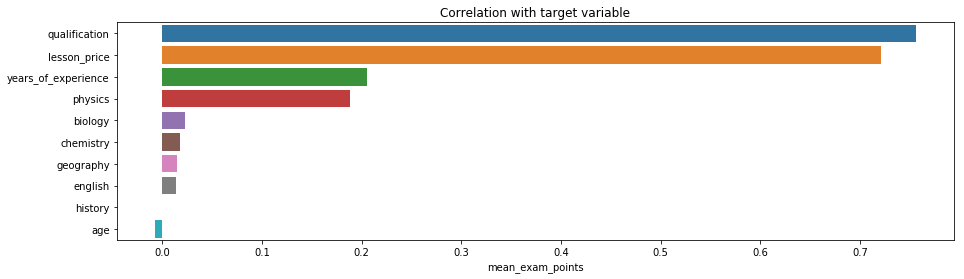

In [21]:
#Кореляция факторов с целевой переменной
cor = df.corr().iloc[:-1,-1].sort_values(ascending=False)

plt.figure(figsize=(15, cor.shape[0] * 0.4))
sns.barplot(x=cor, y=cor.index)
plt.title('Correlation with target variable')
plt.show();

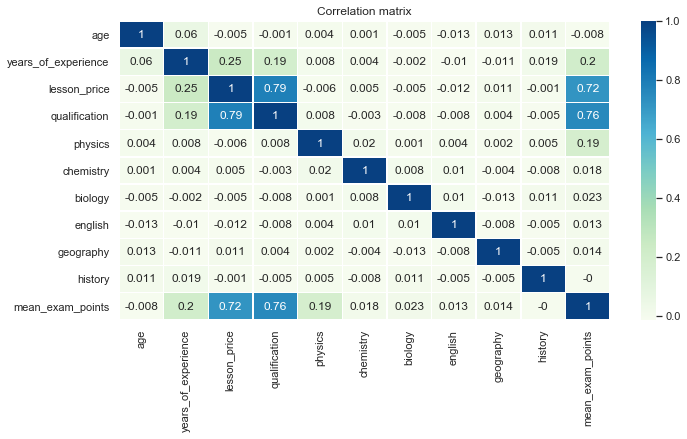

In [23]:
#Матрица Корреляции факторов
heatmap(df)

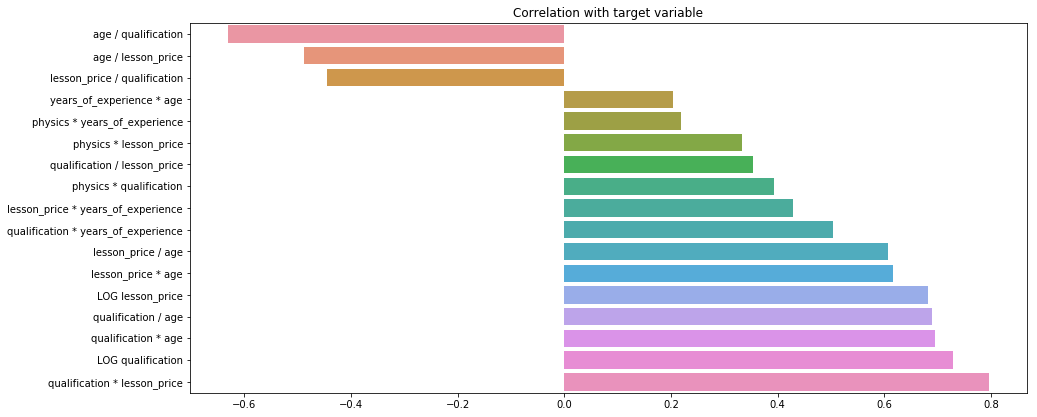

In [22]:
#Вывод наиболее скоррелированных с целевой переменной комбинаций признаков (умножение, деление, степени) 
df1, df1_test = feature_generation(df, df_test, TARGET_NAME, lo_limit=-0.2, hi_limit = 0.2, plot_cor=True, powers=[])

# Создание и валидация моделей

In [27]:
%%time
mnk = mnk_model(model_type='regression', L1=0.1, L2=0.1)
rfm = RandomForest(model_type='regression', n_estimators=100, min_data_in_leaf=20, max_depth=12,random_state=42, split_points=-1)
gb = GradientBoosting(eta=0.35, n_estimators=20, min_data_in_leaf=30, max_depth=12, random_state=42, model_type='regression', n_batches=2, split_points=100)

models = {'mnk': mnk, 'gb':gb, 'rfm':rfm}
#models = {'mnk': mnk}
# Расчет показателей модели для случая с базовой обработкой данных (метрики лучше)
df_result, df_test_result, model_list = check_models(df=df,
                                                   df_test=df_test,
                                                   TARGET_NAME=TARGET_NAME,
                                                   models=models,
                                                   target_class_ratio=0.50,
                                                   random_state=42,
                                                   SKF_splits=5,
                                                   fold_report=True,
                                                   train_report=False,
                                                   data_pr=True,
                                                   scaler_type='std',
                                                   model_type='regression')


FOLD 1 REPORT
Model                        MAE             RMSE               R2
mnk_1_valid               6.4482           8.1307           0.6419
gb_1_valid                 5.289           6.9754           0.7364
rfm_1_valid               4.9597           6.4673           0.7734

FOLD 2 REPORT
Model                        MAE             RMSE               R2
mnk_2_valid               6.3012           8.0005           0.6492
gb_2_valid                5.2689            6.839           0.7436
rfm_2_valid                4.917            6.449            0.772

FOLD 3 REPORT
Model                        MAE             RMSE               R2
mnk_3_valid               6.1313            7.841            0.663
gb_3_valid                5.2387           6.9219           0.7374
rfm_3_valid               4.8202           6.3439           0.7794

FOLD 4 REPORT
Model                        MAE             RMSE               R2
mnk_4_valid               6.2478           8.0157           0.6461
gb

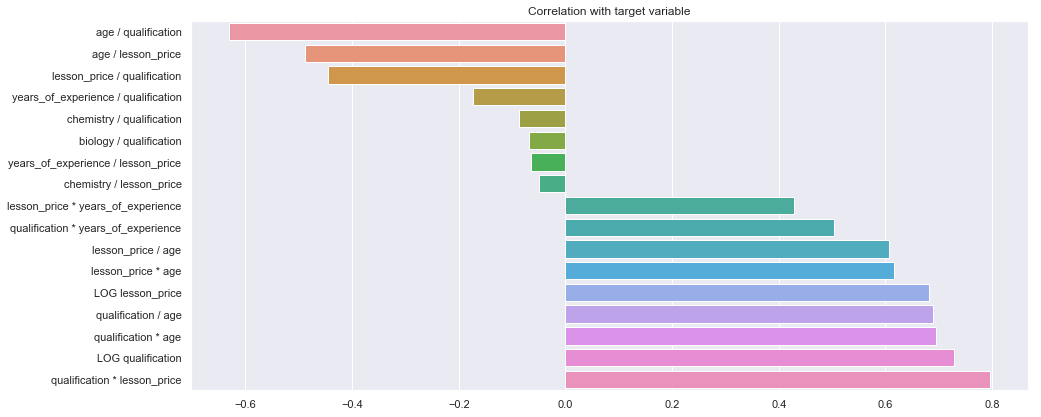


FOLD 1 REPORT
Model                        MAE             RMSE               R2
gb_1_valid                5.5947           7.2531            0.715
rfm_1_valid               4.9629           6.5096           0.7705

FOLD 2 REPORT
Model                        MAE             RMSE               R2
gb_2_valid                5.3028           6.9231           0.7373
rfm_2_valid               4.8556           6.4073            0.775

FOLD 3 REPORT
Model                        MAE             RMSE               R2
gb_3_valid                5.3125           6.9522           0.7351
rfm_3_valid               4.8107           6.3354             0.78

FOLD 4 REPORT
Model                        MAE             RMSE               R2
gb_4_valid                5.2656           6.9529           0.7337
rfm_4_valid               4.7599           6.2838           0.7825

FOLD 5 REPORT
Model                        MAE             RMSE               R2
gb_5_valid                5.3963           7.1392     

In [28]:
%%time

mnk = mnk_model(model_type='regression', L1=0.1, L2=0.1)
rf_private = RandomForest(model_type='regression', n_estimators=100, min_data_in_leaf=20, max_depth=12,random_state=42, split_points=-1)
gb = GradientBoosting(eta=0.35, n_estimators=20, min_data_in_leaf=30, max_depth=12, random_state=42, model_type='regression', n_batches=2, split_points=100)

models = {'gb':gb, 'rfm':rfm}

#Добавление к исходному массиву наиболее скоррелированного признака - улучшает качество модели
df1, df1_test = feature_generation(df, df_test, TARGET_NAME, lo_limit=-0.05, hi_limit = 0.4, plot_cor=True, powers=[])

# Расчет показателей моделей для случая с дополнительными переменными (метрики лучше)
df1_result, df1_test_result, model_list_1 = check_models(df=df1,
                                                   df_test=df1_test,
                                                   TARGET_NAME=TARGET_NAME,
                                                   models=models,                                                     
                                                   target_class_ratio=0.50,
                                                   random_state=42,
                                                   SKF_splits=5,
                                                   fold_report=True,
                                                   train_report=False,
                                                   data_pr=True,
                                                   scaler_type='std',
                                                   model_type='regression')

In [32]:
df1_test_result.head()

,index,gb,gb_p,rfm,rfm_p
0,10000,55.707589,0.0,54.599243,0.0
1,10001,63.118658,0.0,63.378848,0.0
2,10002,51.666523,0.0,47.704213,0.0
3,10003,86.948399,0.0,90.735664,0.0
4,10004,84.993402,0.0,89.022574,0.0


# Вывод предсказний в файл

In [33]:
# Список столбоц в отчете df_test_result которые необходимо вывести в качестве предсказания
#predict_cols = [1 + i*2 for i in range(int((df_test_result.shape[1] - 1) / 2))]
predict_cols = [3]


# Расчет усредненного предсказания вероятности по всем моделям
y_test_pred = np.sum(df1_test_result.iloc[:, predict_cols], axis=1) / len(predict_cols)

pd.DataFrame({'Id': df1_test_result['index'],
              TARGET_NAME: y_test_pred}).to_csv(sub_repot_path, index=False)

print('\nЗапись в файл:', sub_repot_path, '\n')


Запись в файл: D:/Personal/Lesha/Data Science & AI/kaggle/Competitions/Expected Math Exam Result/Ushakov_submission_mean_exam_points.csv 

